## Kaggle Projects: House Price - Adavanced Regression Techniques

# Importing data from kaggle

In [ ]:
! rm -r /root/.kaggle
! mkdir /root/.kaggle
! cp /content/drive/MyDrive/ColabNotebooks/DeepLearning/kaggle.json /root/.kaggle
import kaggle


In [ ]:
! kaggle competitions download -c house-prices-advanced-regression-techniques

house-prices-advanced-regression-techniques.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip -q house-prices-advanced-regression-techniques.zip

replace data_description.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


# Importing Essential Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import datetime as dt

# Functions



## get_null_values
(To get the Columns with Null Values)

In [ ]:
def get_null_values(df):
  null_features = []
  features = list(df.columns)
  for feature in features:
    #print(feature)
    feature_shape = df[df[feature].isna()].shape[0]
    if feature_shape > 0:
      print(feature, feature_shape, df[feature].dtype)
      null_features.append(feature)
  return null_features

## encode_fillnull
(To fill null values in a categorical column and Encode it as per the correlation with Saleprice)

In [ ]:
def encode_fillnull(df, features, mapper_dict, target= None, plot=False):
  #removing null values
  for feature in features:
    print(feature)
    df[feature].fillna('other', inplace=True)
    if target is not None:            # for training data
      # encoding preserved correlation with target feature
      values = list(df.groupby(feature)[target].mean().sort_values().index)
      scale_mapper = {value: index for index, value in enumerate(values)}
      encoded_feature = feature + "Encoded"
      df[encoded_feature] = df[feature].replace(scale_mapper)

      mapper_dict[feature] = values

    else :                # for test data
      values = mapper_dict[feature]
      scale_mapper = {value: index for index, value in enumerate(values)}
      encoded_feature = feature + "Encoded"
      df[encoded_feature] = df[feature].replace(scale_mapper)

  if plot == True:
    try :
      fig, ax = plt.subplots(nrows= len(features), ncols = 2, figsize=(15, 15))
      for index, feature in enumerate(features):
        encoded_feature = feature + "Encoded"
        sns.barplot(data = df, x=feature, y=target, ax=ax[index, 0])
        sns.barplot(data = df, x=encoded_feature, y=target, ax=ax[index, 1])
      fig.show()
    except :
      print("Errr : You Need to provide traget feature for the plot!")





## year_to_age
To get new feature age from year

In [ ]:
def year_to_age(df, date_features):
  today = dt.datetime.now().year
  print(type(today))
  for dates in date_features:
    print(dates)
   # df[dates] = pd.to_datetime(df[dates])
    df[dates].fillna(today, inplace=True)
    age = dates+ '_Age'
    df[age] = today - df[dates]
  print(today)

## remove_outliers

In [ ]:
def remove_outliers(data, features):
  for feature in features:
    print(f'feature : {feature}')
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 -Q1
    print(f'Q1 = {Q1}, Q3 = {Q3}')
    low = Q1 - (1.5*IQR)
    high = Q3 + 1.5*IQR
    print(f'Low = {low}, High = {high}')

    data = data[(data[feature]>= low) & (data[feature]<= high)]

  return data

Let't check the shape, features and Null values in the data set

In [ ]:
os.listdir("./")

['.config',
 'test.csv',
 'train.csv',
 'data_description.txt',
 'drive',
 'sample_submission.csv',
 'house-prices-advanced-regression-techniques.zip',
 'sample_data']

In [ ]:
train_df = pd.read_csv("train.csv")

In [ ]:
test_df = pd.read_csv('test.csv')
sample = pd.read_csv("sample_submission.csv")

In [ ]:
sample.sample(10)

,Id,SalePrice
245,1706,173622.088728
78,1539,175182.950899
1208,2669,187323.318406
395,1856,183570.337897
448,1909,154650.199046
213,1674,180690.274753
1050,2511,164454.967964
1387,2848,158540.947801
876,2337,185191.359443
1084,2545,195531.754886


In [ ]:
train_df.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [ ]:
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


# Data Analysis  

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

## Null Values

The data has 81 features (Columns) and 1460 rows. Just from eyebaling we can conclude some of the features insignifcant for the model. They should be dropped at the beginning. They are
1. Id : it just the index
2. features that have a lot of null values.

for the safeside let's set a cutoff count for null values in a featuer to be 50% of the total data.


In [ ]:
features = list(train_df.columns)
null_cutoff = train_df.shape[0]/2
drop_features =[]
print("Feature having null values more than the cutoff : ")
for feature in features:
  if train_df[train_df[feature].isna()].shape[0] > null_cutoff:
    drop_features.append(feature)


print(drop_features)
#drop_features = drop_features + ["Id"]
print("Features to be Dropped : ", drop_features)
train_df.drop(columns = drop_features, inplace= True)

Feature having null values more than the cutoff : 
['Alley', 'PoolQC', 'Fence', 'MiscFeature']
Features to be Dropped :  ['Alley', 'PoolQC', 'Fence', 'MiscFeature']


Same is true for test data

In [ ]:
test_df.drop(columns = drop_features, inplace= True)

Let's drop these features right away along with Id column

We still have a feature "FireplaceQu" which has a lot of null values. Let's see what we can do about it

In [ ]:
train_df.loc[:, 'FireplaceQu'].value_counts()

Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

It make sense to drop the "FireplaceQu" feature too

In [ ]:
train_df.drop(columns = ['FireplaceQu'], inplace = True)
test_df.drop(columns = ['FireplaceQu'], inplace = True)
drop_features.append("FireplaceQu")

Let's check other Null value feature and what can be done about it

In [ ]:
get_null_values(test_df)

MSZoning 4 object
LotFrontage 227 float64
Utilities 2 object
Exterior1st 1 object
Exterior2nd 1 object
MasVnrType 16 object
MasVnrArea 15 float64
BsmtQual 44 object
BsmtCond 45 object
BsmtExposure 44 object
BsmtFinType1 42 object
BsmtFinSF1 1 float64
BsmtFinType2 42 object
BsmtFinSF2 1 float64
BsmtUnfSF 1 float64
TotalBsmtSF 1 float64
BsmtFullBath 2 float64
BsmtHalfBath 2 float64
KitchenQual 1 object
Functional 2 object
GarageType 76 object
GarageYrBlt 78 float64
GarageFinish 78 object
GarageCars 1 float64
GarageArea 1 float64
GarageQual 78 object
GarageCond 78 object
SaleType 1 object


In [ ]:
get_null_values(train_df)

LotFrontage 259 float64
MasVnrType 8 object
MasVnrArea 8 float64
BsmtQual 37 object
BsmtCond 37 object
BsmtExposure 38 object
BsmtFinType1 37 object
BsmtFinType2 38 object
Electrical 1 object
GarageType 81 object
GarageYrBlt 81 float64
GarageFinish 81 object
GarageQual 81 object
GarageCond 81 object


In [ ]:
test_df.shape

(1459, 75)

In [ ]:
train_df.shape

(1460, 76)

The last five features which are all related to Garage have same number of Null values. Let's chack if they are same rows with all the null values.

In [ ]:
train_df[train_df['GarageType'].isna()].loc[:, ['GarageArea', 'GarageCars', 'GarageType', 'GarageYrBlt', "GarageFinish", "GarageQual", "GarageCond"]]

,GarageArea,GarageCars,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond
39,0,0,NaN,NaN,NaN,NaN,NaN
48,0,0,NaN,NaN,NaN,NaN,NaN
78,0,0,NaN,NaN,NaN,NaN,NaN
88,0,0,NaN,NaN,NaN,NaN,NaN
89,0,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1349,0,0,NaN,NaN,NaN,NaN,NaN
1407,0,0,NaN,NaN,NaN,NaN,NaN
1449,0,0,NaN,NaN,NaN,NaN,NaN
1450,0,0,NaN,NaN,NaN,NaN,NaN


From the above data We can conclude these houses have no Garage. That means Instead of dropping these rows we can replace the null values with 0.

In [ ]:
train_df.loc[:, ['GarageArea', 'GarageCars', 'GarageType', 'GarageYrBlt', "GarageFinish", "GarageQual", "GarageCond"]]

,GarageArea,GarageCars,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond
0,548,2,Attchd,2003.0,RFn,TA,TA
1,460,2,Attchd,1976.0,RFn,TA,TA
2,608,2,Attchd,2001.0,RFn,TA,TA
3,642,3,Detchd,1998.0,Unf,TA,TA
4,836,3,Attchd,2000.0,RFn,TA,TA
...,...,...,...,...,...,...,...
1455,460,2,Attchd,1999.0,RFn,TA,TA
1456,500,2,Attchd,1978.0,Unf,TA,TA
1457,252,1,Attchd,1941.0,RFn,TA,TA
1458,240,1,Attchd,1950.0,Unf,TA,TA


We want to replace the null Values but the complication is some of the features are categorical while some are numerical. Also replacing null values with zero might not be a good idea because It can disturbe the correlation of the feature wiht traget column (SalesPrice). Also we will have to encode our categorical columns into numetical one eventually. So we have three goals
1. Replace the null values
2. label encode the categorical columns
3. do not disturb the correlation with the target.


GarageType

We will make a function to prevent the repetitions (Eventually we will have to do all this to the test data too.)

In [ ]:
mapper_df = dict()

GarageType
GarageFinish
GarageQual
GarageCond


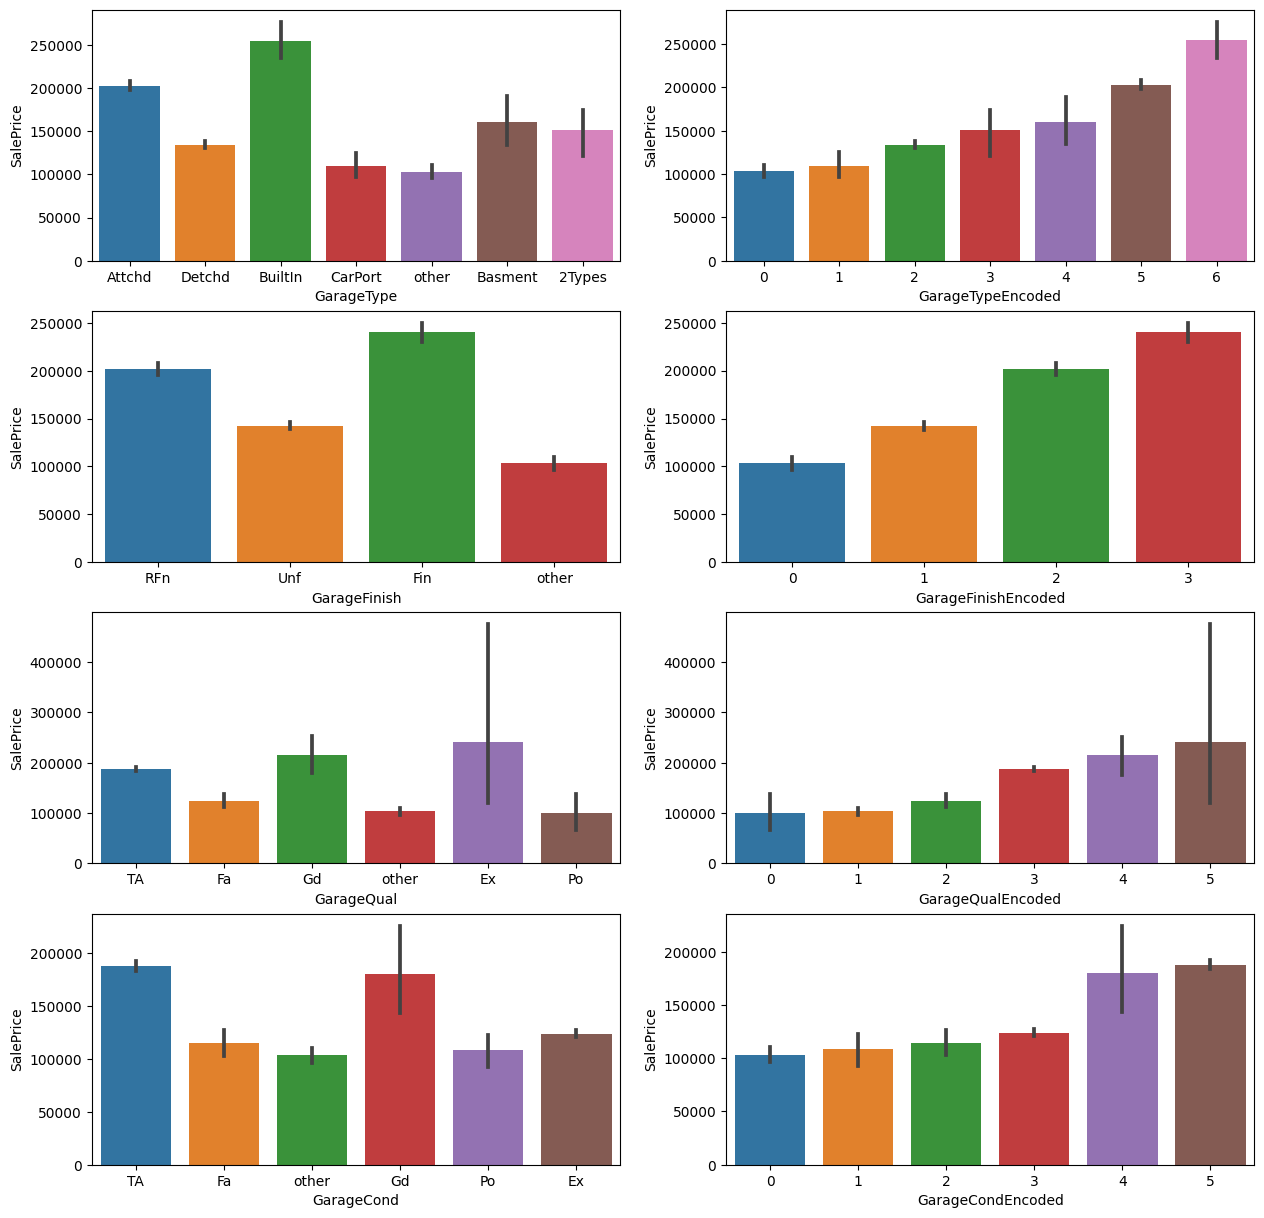

In [ ]:
garage_list = ['GarageType', "GarageFinish", "GarageQual", "GarageCond"]
encode_fillnull(train_df, garage_list, mapper_df, target="SalePrice", plot=True)

In [ ]:
encode_fillnull(test_df, garage_list, mapper_df, target=None, plot=False)

GarageType
GarageFinish
GarageQual
GarageCond


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   1460 non-null   int64  
 1   MSSubClass           1460 non-null   int64  
 2   MSZoning             1460 non-null   object 
 3   LotFrontage          1201 non-null   float64
 4   LotArea              1460 non-null   int64  
 5   Street               1460 non-null   object 
 6   LotShape             1460 non-null   object 
 7   LandContour          1460 non-null   object 
 8   Utilities            1460 non-null   object 
 9   LotConfig            1460 non-null   object 
 10  LandSlope            1460 non-null   object 
 11  Neighborhood         1460 non-null   object 
 12  Condition1           1460 non-null   object 
 13  Condition2           1460 non-null   object 
 14  BldgType             1460 non-null   object 
 15  HouseStyle           1460 non-null   o

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 79 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   1459 non-null   int64  
 1   MSSubClass           1459 non-null   int64  
 2   MSZoning             1455 non-null   object 
 3   LotFrontage          1232 non-null   float64
 4   LotArea              1459 non-null   int64  
 5   Street               1459 non-null   object 
 6   LotShape             1459 non-null   object 
 7   LandContour          1459 non-null   object 
 8   Utilities            1457 non-null   object 
 9   LotConfig            1459 non-null   object 
 10  LandSlope            1459 non-null   object 
 11  Neighborhood         1459 non-null   object 
 12  Condition1           1459 non-null   object 
 13  Condition2           1459 non-null   object 
 14  BldgType             1459 non-null   object 
 15  HouseStyle           1459 non-null   o

Next Let's Check the other Null values

In [ ]:
get_null_values(train_df)

LotFrontage 259 float64
MasVnrType 8 object
MasVnrArea 8 float64
BsmtQual 37 object
BsmtCond 37 object
BsmtExposure 38 object
BsmtFinType1 37 object
BsmtFinType2 38 object
Electrical 1 object
GarageYrBlt 81 float64


In [ ]:
get_null_values(test_df)

MSZoning 4 object
LotFrontage 227 float64
Utilities 2 object
Exterior1st 1 object
Exterior2nd 1 object
MasVnrType 16 object
MasVnrArea 15 float64
BsmtQual 44 object
BsmtCond 45 object
BsmtExposure 44 object
BsmtFinType1 42 object
BsmtFinSF1 1 float64
BsmtFinType2 42 object
BsmtFinSF2 1 float64
BsmtUnfSF 1 float64
TotalBsmtSF 1 float64
BsmtFullBath 2 float64
BsmtHalfBath 2 float64
KitchenQual 1 object
Functional 2 object
GarageYrBlt 78 float64
GarageCars 1 float64
GarageArea 1 float64
SaleType 1 object


We can see the same pattern with Basement columns with initials "Bsmt"

 There are two ambiguous rows with null values in only one of the feature related to Basement ("BsmtFinType2" and "BsmtExposure") which are very insignificant and we can conviniently drop the both rows

In [ ]:
bft2 = train_df[train_df['BsmtFinType2'].isna()].loc[:, ["BsmtFinSF1", "BsmtFinSF2", 'BsmtQual', 'BsmtCond', "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]]

In [ ]:
bE = train_df[train_df['BsmtExposure'].isna()].loc[:, ["BsmtFinSF1", "BsmtFinSF2", 'BsmtQual', 'BsmtCond', "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]]

In [ ]:
pd.concat([bft2, bE]).drop_duplicates(keep=False)

,BsmtFinSF1,BsmtFinSF2,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2
332,1124,479,Gd,TA,No,GLQ,NaN
948,0,0,Gd,TA,NaN,Unf,Unf


In [ ]:
train_df.shape

(1460, 80)

In [ ]:
test_df.shape

(1459, 79)

In [ ]:
get_null_values(train_df)

LotFrontage 259 float64
MasVnrType 8 object
MasVnrArea 8 float64
BsmtQual 37 object
BsmtCond 37 object
BsmtExposure 38 object
BsmtFinType1 37 object
BsmtFinType2 38 object
Electrical 1 object
GarageYrBlt 81 float64


Now all the basement features have same null values in the row where houses don't have the basement. So we can use the fillnull_n_encode function defined earlier to redefine the features.

BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2


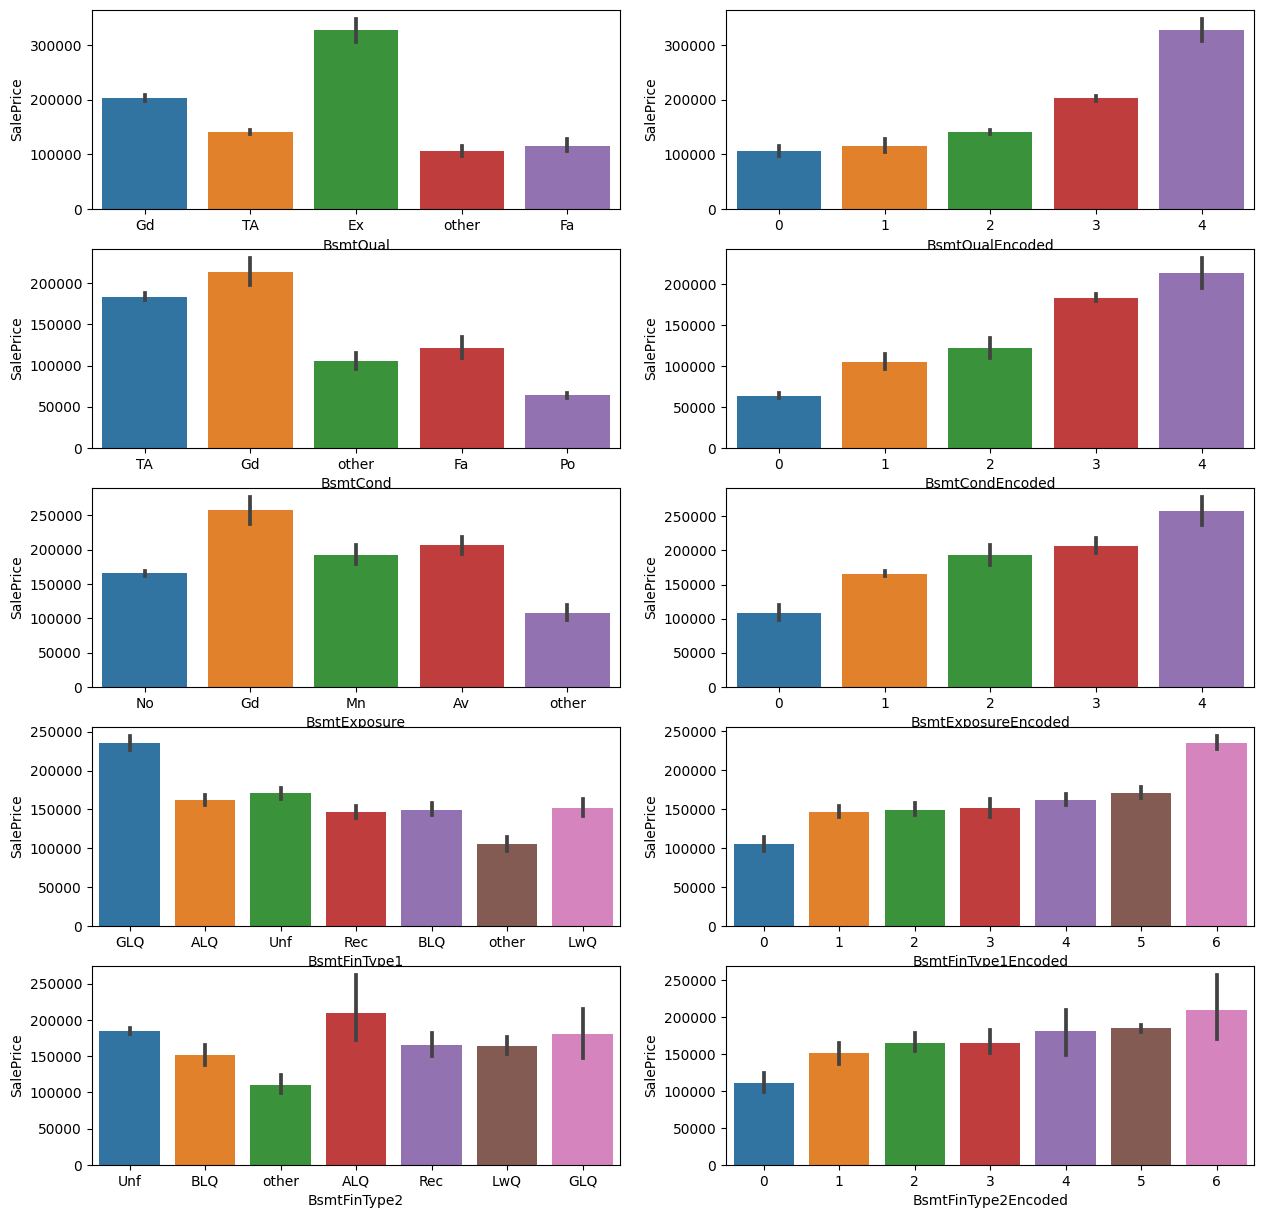

In [ ]:
bsmt_list = ['BsmtQual', 'BsmtCond', "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]
encode_fillnull(train_df, bsmt_list, mapper_df, target="SalePrice", plot=True)
encode_fillnull(test_df, bsmt_list, mapper_df, target=None, plot=False)

In [ ]:
test_df.shape

(1459, 84)

In [ ]:
train_df.shape

(1460, 85)

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 84 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   1459 non-null   int64  
 1   MSSubClass           1459 non-null   int64  
 2   MSZoning             1455 non-null   object 
 3   LotFrontage          1232 non-null   float64
 4   LotArea              1459 non-null   int64  
 5   Street               1459 non-null   object 
 6   LotShape             1459 non-null   object 
 7   LandContour          1459 non-null   object 
 8   Utilities            1457 non-null   object 
 9   LotConfig            1459 non-null   object 
 10  LandSlope            1459 non-null   object 
 11  Neighborhood         1459 non-null   object 
 12  Condition1           1459 non-null   object 
 13  Condition2           1459 non-null   object 
 14  BldgType             1459 non-null   object 
 15  HouseStyle           1459 non-null   o

In [ ]:
get_null_values(train_df)

LotFrontage 259 float64
MasVnrType 8 object
MasVnrArea 8 float64
Electrical 1 object
GarageYrBlt 81 float64


In [ ]:
get_null_values(test_df)

MSZoning 4 object
LotFrontage 227 float64
Utilities 2 object
Exterior1st 1 object
Exterior2nd 1 object
MasVnrType 16 object
MasVnrArea 15 float64
BsmtFinSF1 1 float64
BsmtFinSF2 1 float64
BsmtUnfSF 1 float64
TotalBsmtSF 1 float64
BsmtFullBath 2 float64
BsmtHalfBath 2 float64
KitchenQual 1 object
Functional 2 object
GarageYrBlt 78 float64
GarageCars 1 float64
GarageArea 1 float64
SaleType 1 object


Let's review the next major feature with null values ("LotFrontage")

259 null values (almost 20% of the data)

In [ ]:
train_df[train_df['LotFrontage'].isna()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,SalePrice,GarageTypeEncoded,GarageFinishEncoded,GarageQualEncoded,GarageCondEncoded,BsmtQualEncoded,BsmtCondEncoded,BsmtExposureEncoded,BsmtFinType1Encoded,BsmtFinType2Encoded
7,8,60,RL,NaN,10382,Pave,IR1,Lvl,AllPub,Corner,...,200000,5,2,3,5,3,3,2,4,1
12,13,20,RL,NaN,12968,Pave,IR2,Lvl,AllPub,Inside,...,144000,2,1,3,5,2,3,1,4,5
14,15,20,RL,NaN,10920,Pave,IR1,Lvl,AllPub,Corner,...,157000,5,2,3,5,2,3,1,2,5
16,17,20,RL,NaN,11241,Pave,IR1,Lvl,AllPub,CulDSac,...,149000,5,3,3,5,2,3,1,4,5
24,25,20,RL,NaN,8246,Pave,IR1,Lvl,AllPub,Inside,...,154000,5,1,3,5,2,3,2,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1429,1430,20,RL,NaN,12546,Pave,IR1,Lvl,AllPub,Corner,...,182900,5,3,3,5,3,3,1,2,5
1431,1432,120,RL,NaN,4928,Pave,IR1,Lvl,AllPub,Inside,...,143750,5,2,3,5,3,3,1,3,5
1441,1442,120,RM,NaN,4426,Pave,Reg,Lvl,AllPub,Inside,...,149300,5,2,3,5,3,3,3,6,5
1443,1444,30,RL,NaN,8854,Pave,Reg,Lvl,AllPub,Inside,...,121000,2,1,2,1,2,3,1,5,5


<Axes: xlabel='LotFrontage', ylabel='SalePrice'>

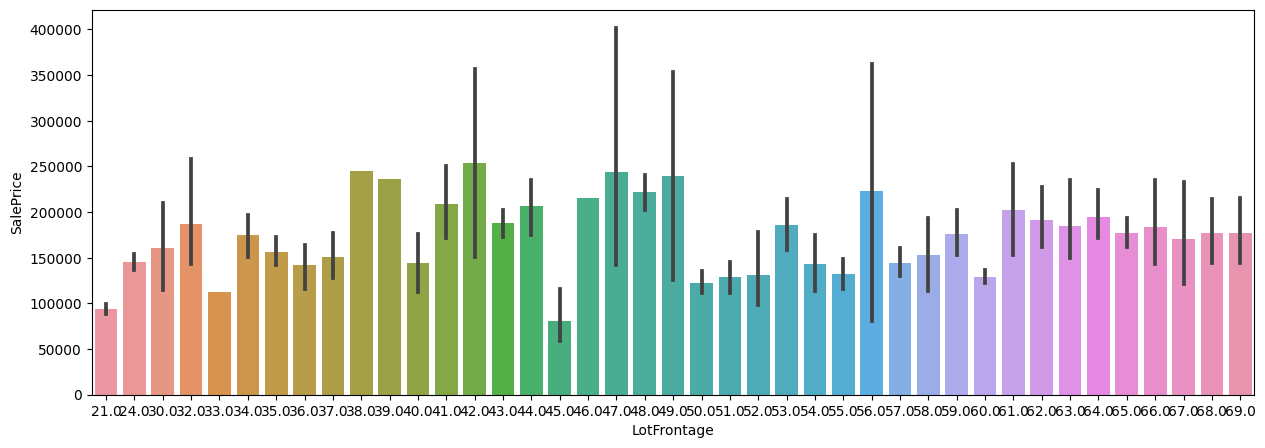

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(15, 5))
sns.barplot(data=train_df[train_df["LotFrontage"]<70], x='LotFrontage', y='SalePrice', ax =ax)

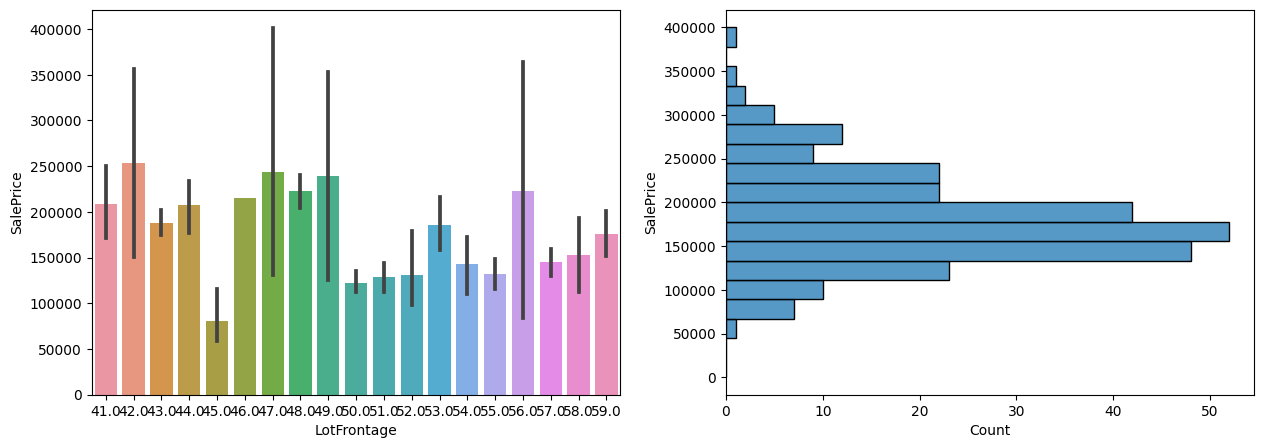

In [ ]:
fig, ax = plt.subplots(1, 2, figsize= (15, 5))
sns.barplot(data=train_df[(train_df["LotFrontage"]>40) & (train_df["LotFrontage"]<60)], x='LotFrontage', y='SalePrice', ax =ax[0])
sns.histplot(data=train_df[train_df['LotFrontage'].isna()], y='SalePrice',binrange=(100, 400000), ax= ax[1], )
fig.show()

 From the above plots (confidence intervals of SalePrice and distribution of SalePrice in null values of LotFronage) we can conclude that the LotFrontage value 0f 56 most suitable value to replace the null values

In [ ]:
train_df['LotFrontage'].fillna(56, inplace=True)
test_df['LotFrontage'].fillna(56, inplace=True)

In [ ]:
get_null_values(test_df)

MSZoning 4 object
Utilities 2 object
Exterior1st 1 object
Exterior2nd 1 object
MasVnrType 16 object
MasVnrArea 15 float64
BsmtFinSF1 1 float64
BsmtFinSF2 1 float64
BsmtUnfSF 1 float64
TotalBsmtSF 1 float64
BsmtFullBath 2 float64
BsmtHalfBath 2 float64
KitchenQual 1 object
Functional 2 object
GarageYrBlt 78 float64
GarageCars 1 float64
GarageArea 1 float64
SaleType 1 object


In [ ]:
train_df[train_df['Electrical'].isna()].loc[: , ['Electrical', 'MasVnrType', 'MasVnrArea', 'SalePrice']]

,Electrical,MasVnrType,MasVnrArea,SalePrice
1379,NaN,None,0.0,167500


In [ ]:
train_df['Electrical'].unique()

array(['SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix', nan], dtype=object)

<Axes: xlabel='Electrical', ylabel='SalePrice'>

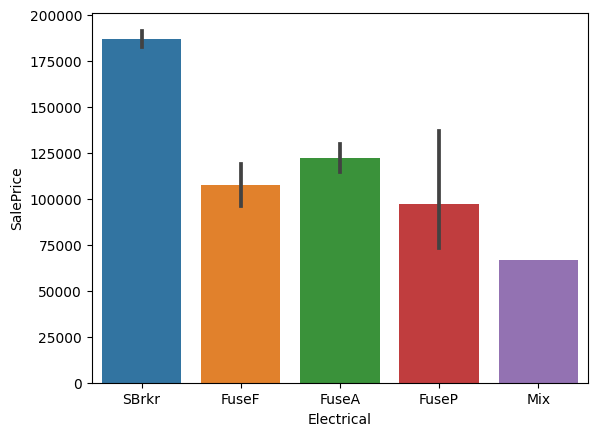

In [ ]:
sns.barplot(data=train_df, x='Electrical', y='SalePrice')

We have two choices here
1. Since its just one row we can just drop the whole row
2. Or we can replace it with the Electrical type in which its SalePrice falls (SBrks)

I'm gonna choose later its a one line code eitherway, and it will take care of encoding too

In [ ]:
train_df['Electrical'].fillna('SBrkr', inplace=True)
test_df['Electrical'].fillna('SBrkr', inplace=True)

In [ ]:
get_null_values(train_df)

MasVnrType 8 object
MasVnrArea 8 float64
GarageYrBlt 81 float64


In [ ]:
get_null_values(test_df)

MSZoning 4 object
Utilities 2 object
Exterior1st 1 object
Exterior2nd 1 object
MasVnrType 16 object
MasVnrArea 15 float64
BsmtFinSF1 1 float64
BsmtFinSF2 1 float64
BsmtUnfSF 1 float64
TotalBsmtSF 1 float64
BsmtFullBath 2 float64
BsmtHalfBath 2 float64
KitchenQual 1 object
Functional 2 object
GarageYrBlt 78 float64
GarageCars 1 float64
GarageArea 1 float64
SaleType 1 object


In [ ]:
train_df[train_df['MasVnrArea'].isna()].loc[:, ["MasVnrArea", 'MasVnrType', 'SalePrice']]

,MasVnrArea,MasVnrType,SalePrice
234,NaN,NaN,216500
529,NaN,NaN,200624
650,NaN,NaN,205950
936,NaN,NaN,184900
973,NaN,NaN,182000
977,NaN,NaN,199900
1243,NaN,NaN,465000
1278,NaN,NaN,237000


In [ ]:
train_df['MasVnrArea'].mean()

103.68526170798899

In [ ]:
train_df['MasVnrType'].unique()

array(['BrkFace', 'None', 'Stone', 'BrkCmn', nan], dtype=object)

In [ ]:
train_df[train_df['MasVnrType'].isna()].loc[:,  ['MasVnrArea','SalePrice']].describe()

,MasVnrArea,SalePrice
count,0.0,8.000000
mean,NaN,236484.250000
std,NaN,93964.474968
min,NaN,182000.000000
25%,NaN,196150.000000
50%,NaN,203287.000000
75%,NaN,221625.000000
max,NaN,465000.000000


In [ ]:
train_df[train_df['MasVnrType'] == 'None'].loc[:,  ['MasVnrArea','SalePrice']].describe()

,MasVnrArea,SalePrice
count,864.000000,864.000000
mean,1.094907,156221.891204
std,18.569659,60708.262798
min,0.000000,34900.000000
25%,0.000000,118991.000000
50%,0.000000,143000.000000
75%,0.000000,181875.000000
max,344.000000,745000.000000


In [ ]:
train_df['MasVnrType'].value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

* The Price range more or less matchs with None type (Mode : maximum occuring value)


In [ ]:
train_df['MasVnrType'].fillna("None", inplace=True)
test_df['MasVnrType'].fillna('None', inplace=True)
train_df['MasVnrArea'].fillna(0, inplace=True)
test_df['MasVnrArea'].fillna(0, inplace=True)

In [ ]:
train_df[(train_df['MasVnrType'] == 'None') & (train_df['MasVnrArea']!=0)].loc[:, ['MasVnrArea']]

,MasVnrArea


In [ ]:
index = list(train_df[(train_df['MasVnrType'] == 'None') & (train_df['MasVnrArea']!=0)].loc[:, ['MasVnrArea']].index)

In [ ]:
for i in index:
  train_df.at[i,'MasVnrArea']= 0

In [ ]:
get_null_values(test_df)

MSZoning 4 object
Utilities 2 object
Exterior1st 1 object
Exterior2nd 1 object
MasVnrArea 15 float64
BsmtFinSF1 1 float64
BsmtFinSF2 1 float64
BsmtUnfSF 1 float64
TotalBsmtSF 1 float64
BsmtFullBath 2 float64
BsmtHalfBath 2 float64
KitchenQual 1 object
Functional 2 object
GarageYrBlt 78 float64
GarageCars 1 float64
GarageArea 1 float64
SaleType 1 object


In [ ]:
test_df[test_df['MasVnrArea'].isna()].loc[:, ['MasVnrType', 'MasVnrArea']]

,MasVnrType,MasVnrArea


In [ ]:
test_index  = list(test_df[(test_df['MasVnrType'] == 'None') & (test_df['MasVnrArea']!= 0)].loc[:, ['MasVnrArea']].index)

In [ ]:
test_index

[209, 992, 1150]

In [ ]:
test_df.loc[test_index, ['MasVnrType', 'MasVnrArea']]

,MasVnrType,MasVnrArea
209,None,0.0
992,None,0.0
1150,None,0.0


In [ ]:
for i in test_index:
  test_df.at[i,'MasVnrArea']= 0

In [ ]:
get_null_values(train_df)

GarageYrBlt 81 float64


In [ ]:
get_null_values(test_df)

MSZoning 4 object
Utilities 2 object
Exterior1st 1 object
Exterior2nd 1 object
BsmtFinSF1 1 float64
BsmtFinSF2 1 float64
BsmtUnfSF 1 float64
TotalBsmtSF 1 float64
BsmtFullBath 2 float64
BsmtHalfBath 2 float64
KitchenQual 1 object
Functional 2 object
GarageYrBlt 78 float64
GarageCars 1 float64
GarageArea 1 float64
SaleType 1 object


Task
1. We need to convert the year into date time format
2. Fill the null values with present date
3. Get the age feature

This can be applied for both 'YearBuilt' and 'GarageYrBlt' features.

In [ ]:
cols = list(train_df.columns)

In [ ]:
'GarageYrBlt'.find("n")

-1

In [ ]:
year_cols = []

for i in cols:
    if(i.find('Year') != -1 or i.find("Yr") != -1):
        year_cols.append(i)

In [ ]:
year_cols

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

In [ ]:
year_to_age(train_df, year_cols)

<class 'int'>
YearBuilt
YearRemodAdd
GarageYrBlt
YrSold
2023


In [ ]:
year_to_age(test_df, year_cols)

<class 'int'>
YearBuilt
YearRemodAdd
GarageYrBlt
YrSold
2023


In [ ]:
get_null_values(train_df)

In [ ]:
null_feat = get_null_values(test_df)

MSZoning 4 object
Utilities 2 object
Exterior1st 1 object
Exterior2nd 1 object
BsmtFinSF1 1 float64
BsmtFinSF2 1 float64
BsmtUnfSF 1 float64
TotalBsmtSF 1 float64
BsmtFullBath 2 float64
BsmtHalfBath 2 float64
KitchenQual 1 object
Functional 2 object
GarageCars 1 float64
GarageArea 1 float64
SaleType 1 object


In [ ]:
train_df.shape

(1460, 89)

In [ ]:
test_df.shape

(1459, 88)

In [ ]:
for feat in null_feat:
  print(feat)
  if test_df[feat].dtype == 'O':
    test_df[feat].fillna(test_df[feat].mode()[0], inplace=True)

  else :
    test_df[feat].fillna(test_df[feat].mean(), inplace=True)

MSZoning
Utilities
Exterior1st
Exterior2nd
BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
BsmtFullBath
BsmtHalfBath
KitchenQual
Functional
GarageCars
GarageArea
SaleType


In [ ]:
_ = get_null_values(test_df)

 Now finally we are done with Null values

## Let's remove the outliers

<Axes: >

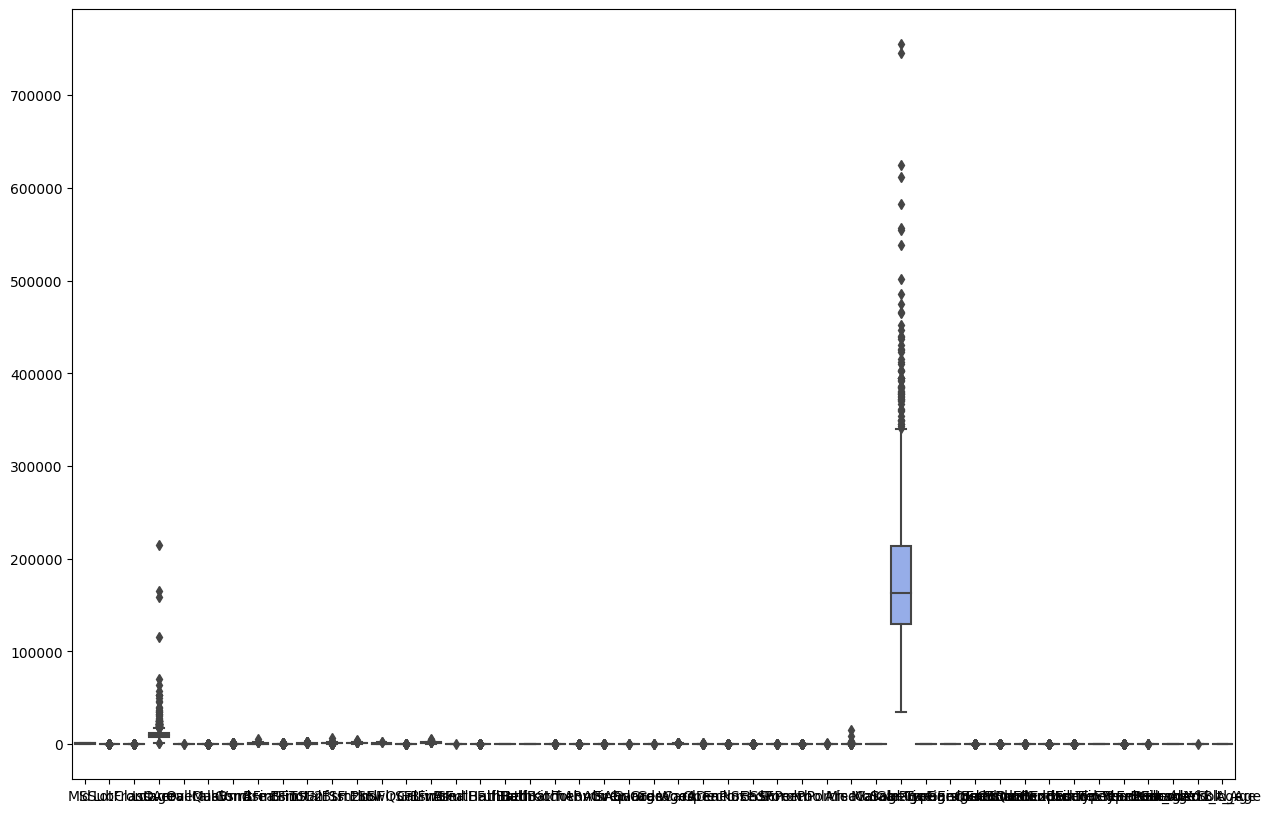

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
sns.boxplot(data=train_df, ax = ax)


Columns  have outliers. Let's plot them separately

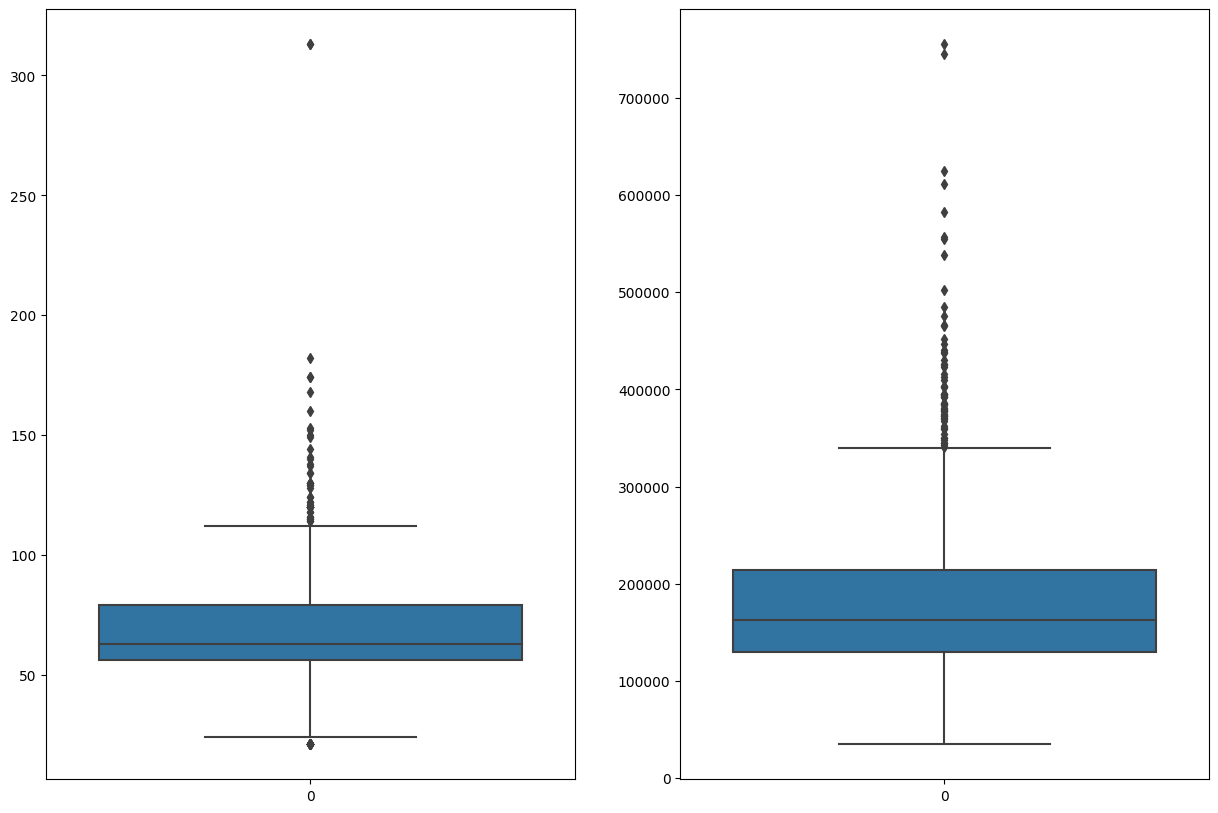

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,10))
sns.boxplot(data=train_df['LotArea], ax = ax[0])
sns.boxplot(data=train_df['SalePrice'], ax = ax[1])
fig.show()

In [ ]:
sample_df = train_df.copy()

In [ ]:
sample_df = remove_outliers(sample_df,  ['SalePrice', 'LotArea'])

feature : SalePrice
Q1 = 129975.0, Q3 = 214000.0
Low = 3937.5, High = 340037.5
feature : LotArea
Q1 = 7442.0, Q3 = 11316.5
Low = 1630.25, High = 17128.25


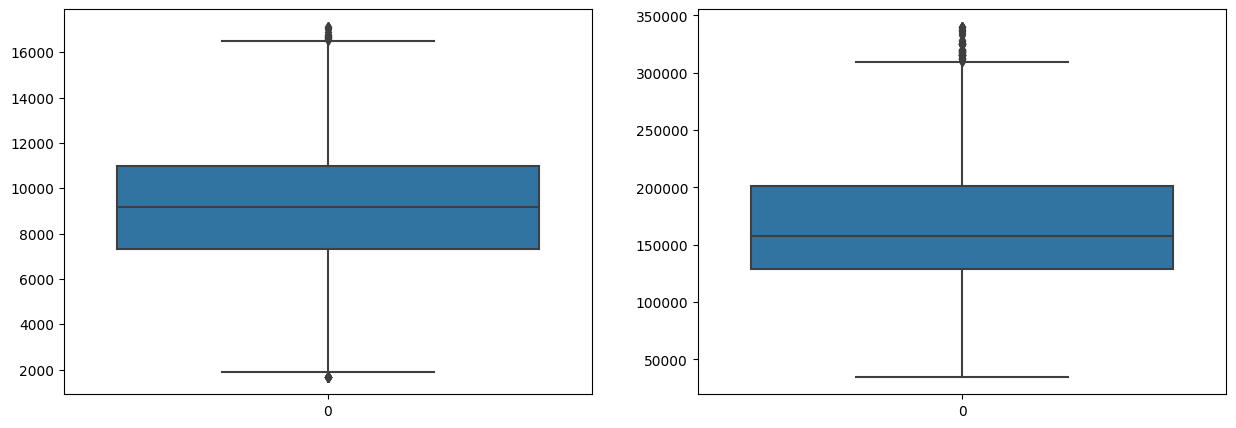

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.boxplot(data=sample_df['LotArea'], ax = ax[0])
sns.boxplot(data=sample_df['SalePrice'], ax = ax[1])
fig.show()

<Axes: >

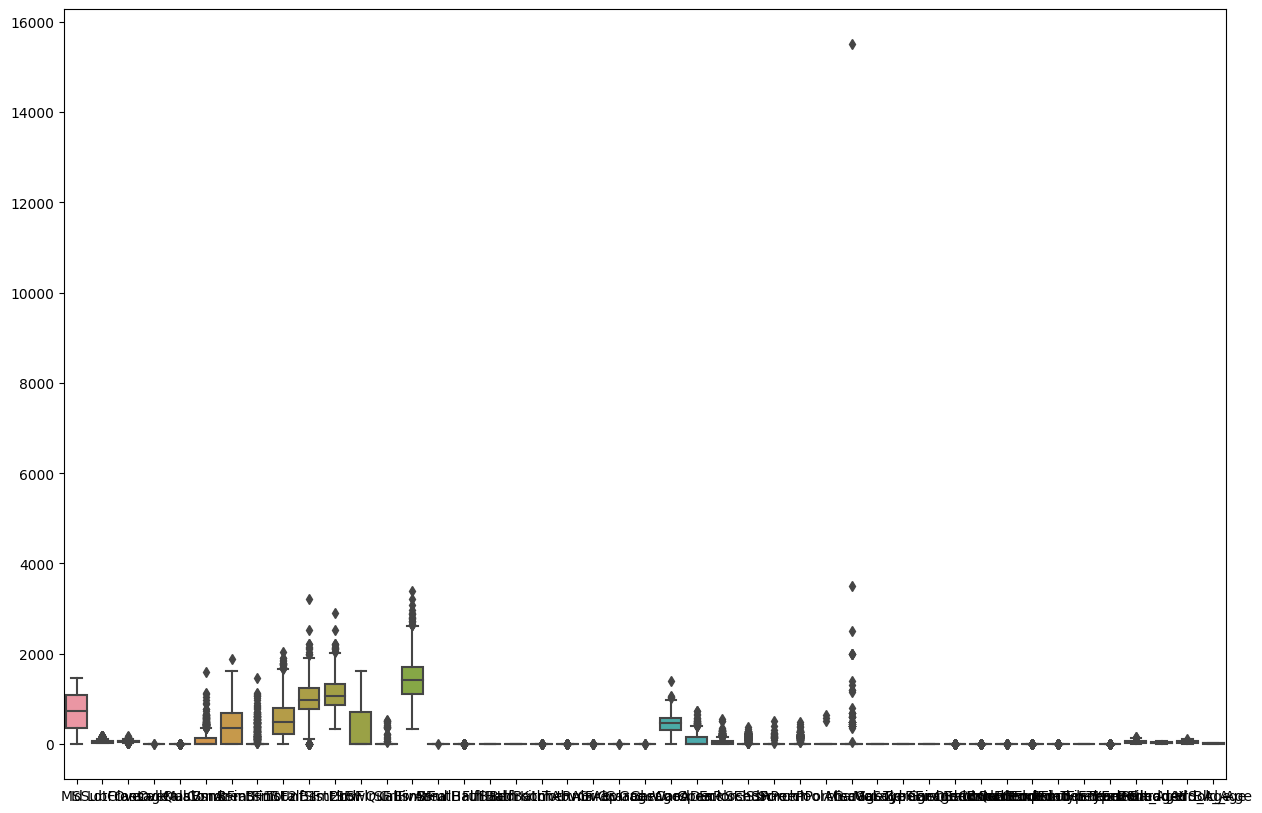

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
sns.boxplot(data=sample_df.drop(columns = ['LotArea', 'SalePrice']), ax = ax)


Removing all the outlier in numerical columns leave us with less then 50% of the original data. Which in not preferable. So we have to prioritize

We only remove "SalePrice", "LotArea" which were  major outliers columns

In [ ]:
train_df = sample_df.copy()

## encoding the categorical features

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 89 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   1460 non-null   int64  
 1   MSSubClass           1460 non-null   int64  
 2   MSZoning             1460 non-null   object 
 3   LotFrontage          1460 non-null   float64
 4   LotArea              1460 non-null   int64  
 5   Street               1460 non-null   object 
 6   LotShape             1460 non-null   object 
 7   LandContour          1460 non-null   object 
 8   Utilities            1460 non-null   object 
 9   LotConfig            1460 non-null   object 
 10  LandSlope            1460 non-null   object 
 11  Neighborhood         1460 non-null   object 
 12  Condition1           1460 non-null   object 
 13  Condition2           1460 non-null   object 
 14  BldgType             1460 non-null   object 
 15  HouseStyle           1460 non-null   o

In [ ]:
cols = list(train_df.columns)
cat_cols = []
for item in cols:
  if train_df[item].dtype == "O":
    cat_cols.append(item)
  else :
    pass

In [ ]:
train_df.shape

(1460, 89)

In [ ]:
encode_fillnull(train_df, cat_cols, mapper_df, target='SalePrice')

MSZoning
Street
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
SaleType
SaleCondition


In [ ]:
encode_fillnull(test_df, cat_cols, mapper_df)

MSZoning
Street
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
SaleType
SaleCondition


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 118 entries, Id to SaleConditionEncoded
dtypes: float64(4), int64(76), object(38)
memory usage: 1.3+ MB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Columns: 117 entries, Id to SaleConditionEncoded
dtypes: float64(12), int64(67), object(38)
memory usage: 1.3+ MB


In [ ]:
test_cols = list(test_df.columns)
test_cats = []
for item in test_cols:
  if test_df[item].dtype == 'O':
    test_cats.append(item)

  else :
    pass

In [ ]:
[item for item in test_cats if item not in cat_cols]


[]

In [ ]:
cat_col = cat_col + bsmt_list + garage_list

In [ ]:
[item for item in cat_cols if item not in cat_col]

[]

# Let's do some general visualisation

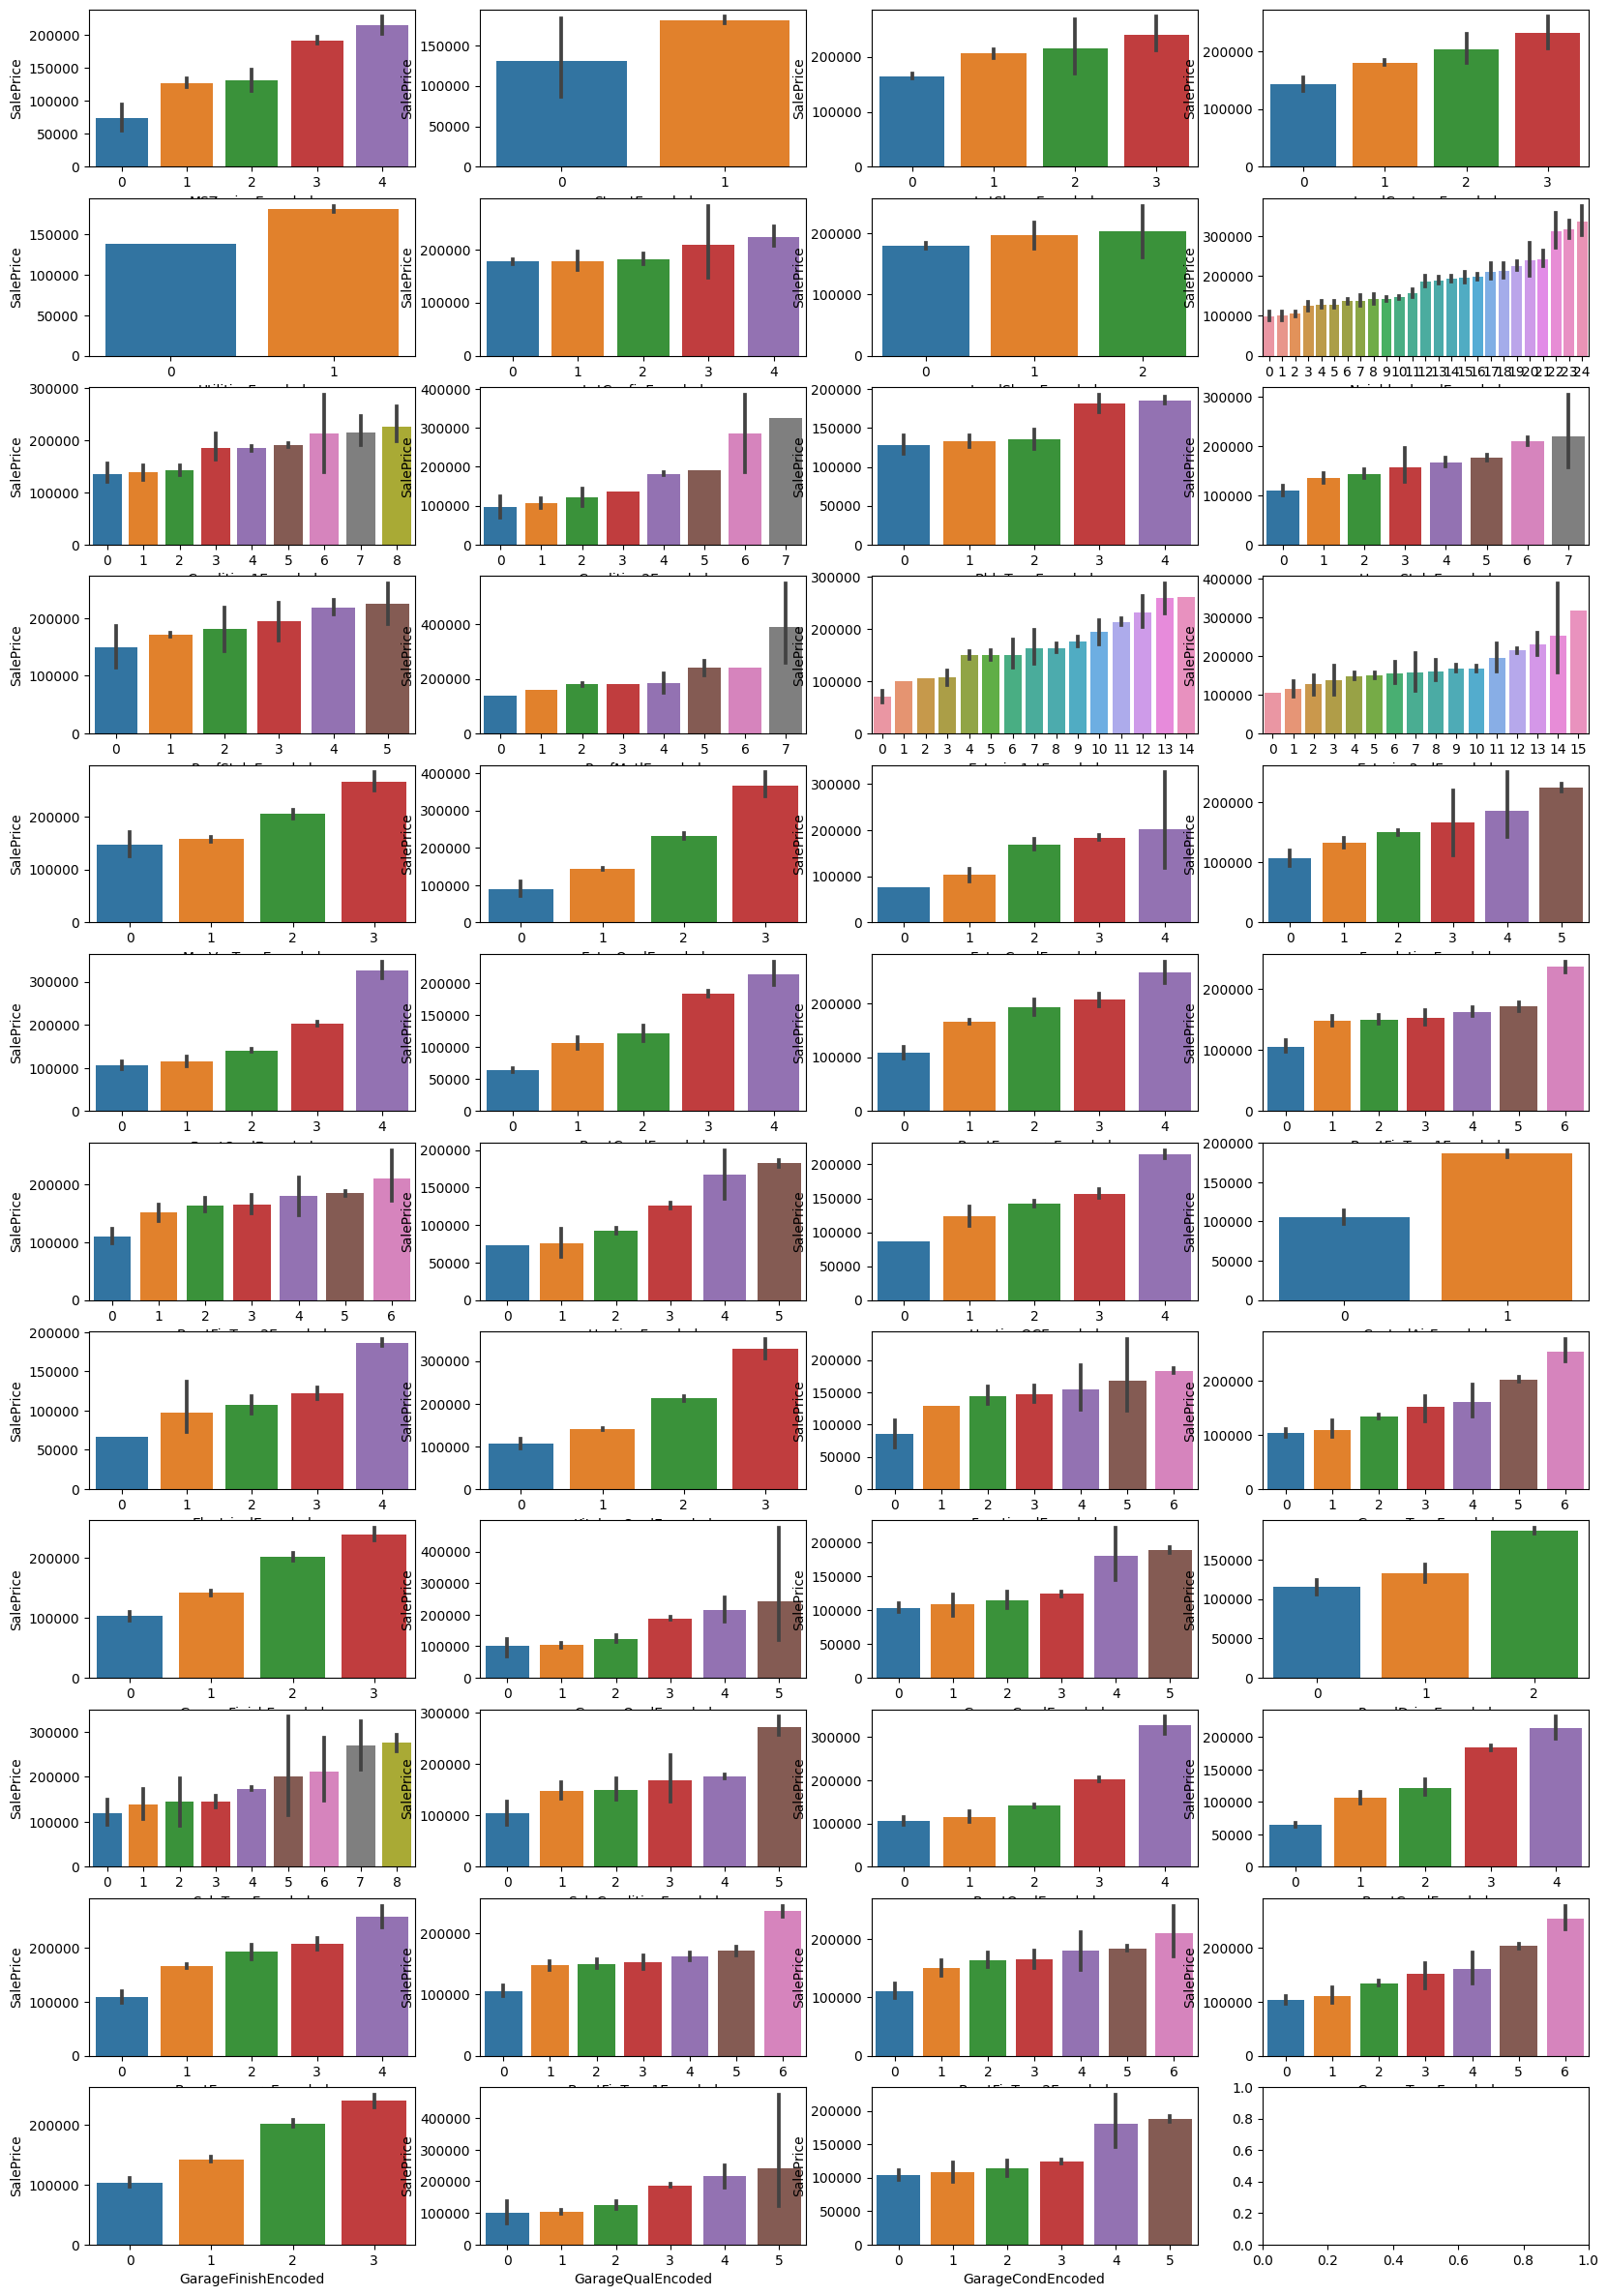

In [ ]:
nrows = int(len(cat_col)/4)+ 1
ncols = 4
fig, ax = plt.subplots(nrows= nrows, ncols = ncols, figsize=(20,30))
for index, feature in enumerate(cat_col):
  i = int((index)/4)
  j = int((index)%4)
  sns.barplot(data=train_df, x=feature+"Encoded", y= 'SalePrice', ax=ax[i, j])
fig.show()

As we can see from the bar plots there is a correlation between saleprice and features in almost all the categorical columns

In [ ]:
len(num_col)

38

In [ ]:
num_col = [item for item in num_col if item not in year_cols]

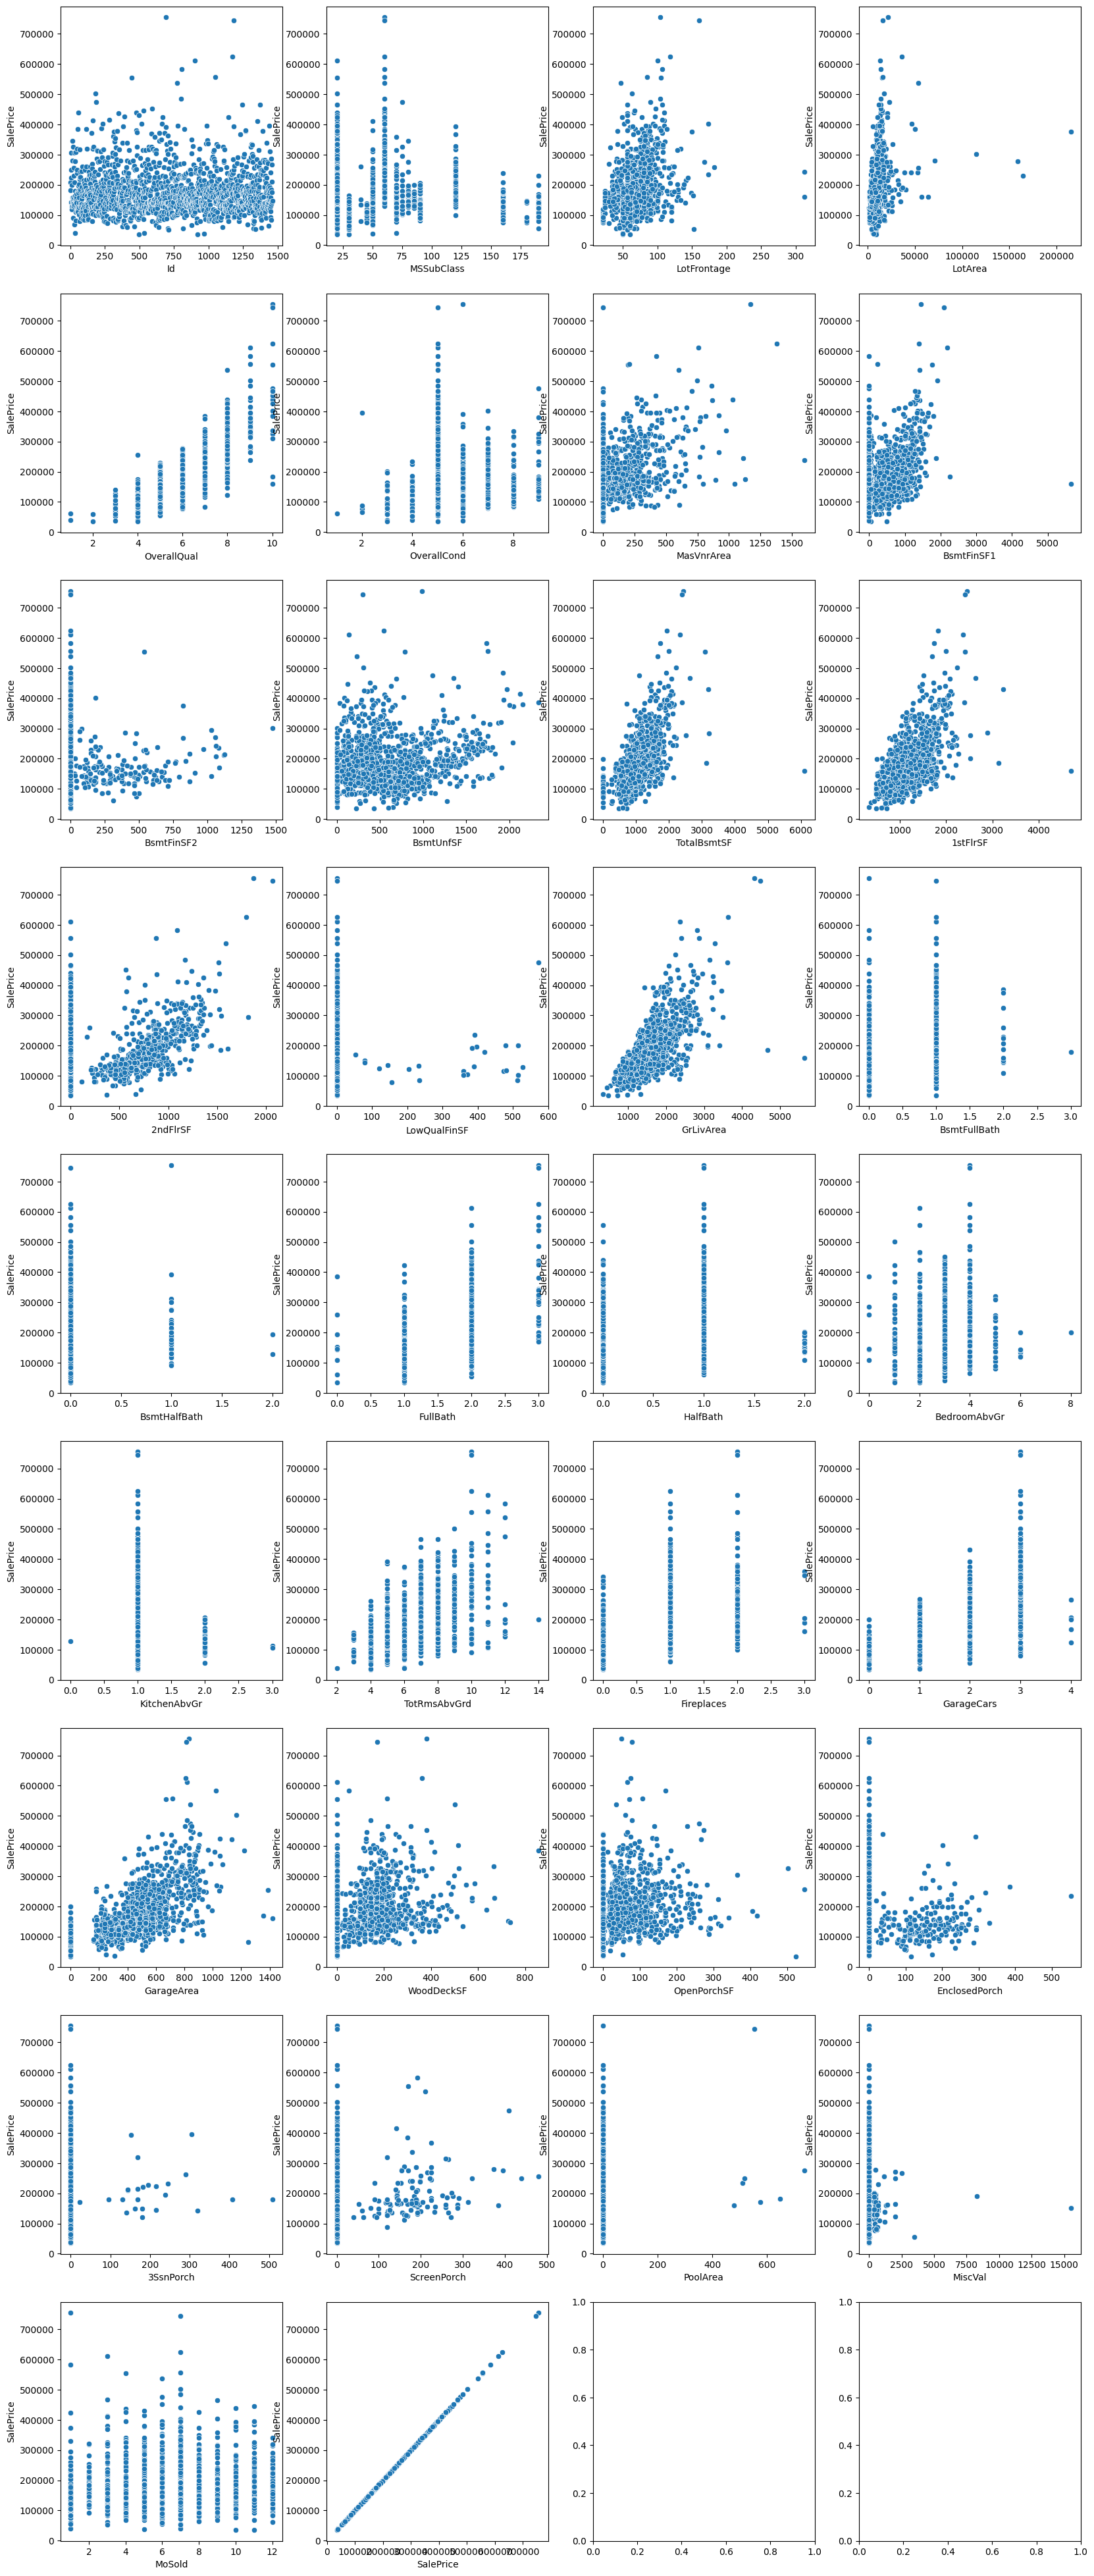

In [ ]:
nrows = int(len(num_col)/4)+ 1
ncols = 4
fig, ax = plt.subplots(nrows= nrows, ncols = ncols, figsize=(20,50))
for index, feature in enumerate(num_col):
  i = int((index)/4)
  j = int((index)%4)
  sns.scatterplot(data=train_df, x=feature, y= 'SalePrice', ax=ax[i, j])
fig.show()

From the above sacatter plots we can see some of the features have no or almost ngligible correlation with the tatget "SalePrice". They can be dropped conviniently.
Those features are ['LowQualFinSF', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

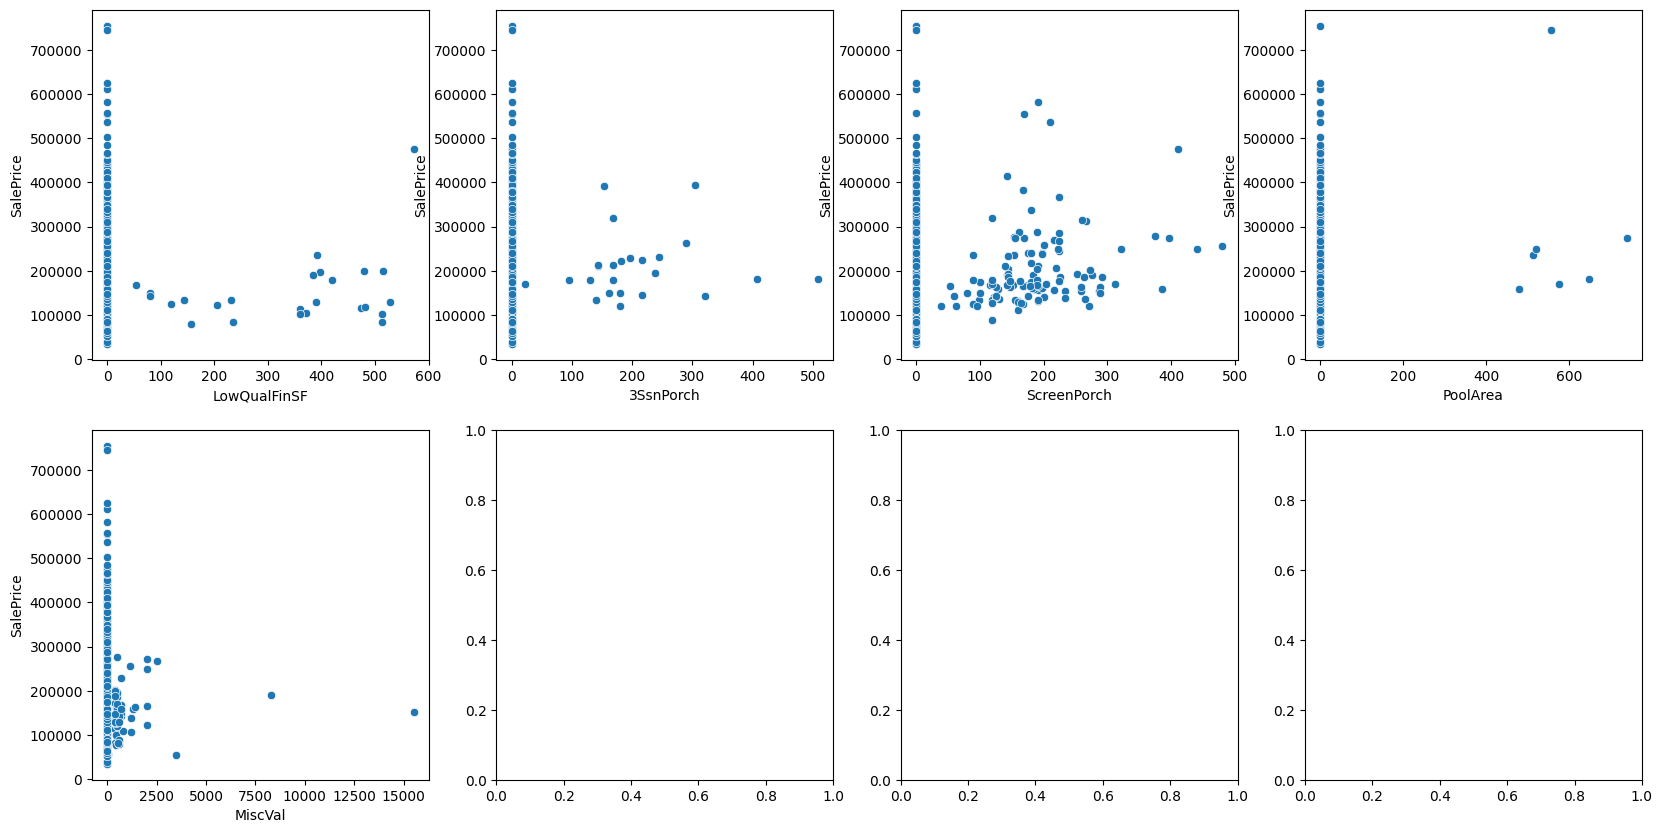

In [ ]:
non_imp_features = ['LowQualFinSF', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']
nrows = int(len(non_imp_features)/4)+ 1
ncols = 4
fig, ax = plt.subplots(nrows= nrows, ncols = ncols, figsize=(20,10))
for index, feature in enumerate(non_imp_features):
  i = int((index)/4)
  j = int((index)%4)
  sns.scatterplot(data=train_df, x=feature, y= 'SalePrice', ax=ax[i, j])
fig.show()

In [ ]:
train_df.shape

(1460, 118)

In [ ]:
test_df.shape

(1459, 117)

With still 68 features left it is hard to investigate each individual feature and its significance. We can uses several techniquest to classify the features according to their significance.
Since this is a regression problem we can use
1. Variance Infaltion Factor
2. Linear Discriminant Analysis
3. Feature importance from Random Forest Regressor

In [ ]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,FoundationEncoded,HeatingEncoded,HeatingQCEncoded,CentralAirEncoded,ElectricalEncoded,KitchenQualEncoded,FunctionalEncoded,PavedDriveEncoded,SaleTypeEncoded,SaleConditionEncoded
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,5,5,4,1,4,2,6,2,4,4
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,2,5,4,1,4,1,6,2,4,4
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,5,5,4,1,4,2,6,2,4,4
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,1,5,3,1,4,2,6,2,4,1
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,5,5,4,1,4,2,6,2,4,4


In [ ]:
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,FoundationEncoded,HeatingEncoded,HeatingQCEncoded,CentralAirEncoded,ElectricalEncoded,KitchenQualEncoded,FunctionalEncoded,PavedDriveEncoded,SaleTypeEncoded,SaleConditionEncoded
0,1461,20,RH,80.0,11622,Pave,Reg,Lvl,AllPub,Inside,...,2,5,2,1,4,1,6,2,4,4
1,1462,20,RL,81.0,14267,Pave,IR1,Lvl,AllPub,Corner,...,2,5,2,1,4,2,6,2,4,4
2,1463,60,RL,74.0,13830,Pave,IR1,Lvl,AllPub,Inside,...,5,5,3,1,4,1,6,2,4,4
3,1464,60,RL,78.0,9978,Pave,IR1,Lvl,AllPub,Inside,...,5,5,4,1,4,2,6,2,4,4
4,1465,120,RL,43.0,5005,Pave,IR1,HLS,AllPub,Inside,...,5,5,4,1,4,2,6,2,4,4


# Dropping Extra columns

In [ ]:
train_df.drop(columns=garage_list, inplace= True)
test_df.drop(columns=garage_list, inplace= True)

In [ ]:

train_df.drop(columns=bsmt_list, inplace=True)
test_df.drop(columns=bsmt_list, inplace=True)
train_df.shape

(1460, 109)

In [ ]:
train_df.drop(columns=year_cols, inplace=True)
test_df.drop(columns=year_cols, inplace=True)

In [ ]:
year_cols

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

In [ ]:
test_cols = list(test_df.columns)
test_cats = []
for item in test_cols:
  if test_df[item].dtype == 'O':
    test_cats.append(item)

  else :
    pass

In [ ]:
train_df.drop(columns=test_cats, inplace=True)
test_df.drop(columns=test_cats, inplace=True)

In [ ]:
train_df.drop(columns=non_imp_features, inplace=True)
test_df.drop(columns=non_imp_features, inplace=True)

In [ ]:
train_df.shape

(1460, 71)

In [ ]:
test_df.shape

(1459, 70)

# Linear Regression

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

In [ ]:
def fn_LinearReg(data, target):
  X = data.copy()
  Y = X[target]
  print("No. of features used : ", len(X.columns)-1 )
  scale = MinMaxScaler()
  X_scaled = scale.fit_transform(X.drop(columns= ['Id', target]))
  X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.1, random_state=0)
  print('Training Features Shape: ', X_train.shape)
  print('Training Labels Shape: ', y_train.shape)
  print('Testing Features Shape: ', X_test.shape)
  print('Testing Labels Shape: ', y_test.shape)
  lr = LinearRegression()
  lr.fit(X_train, y_train)

  score = lr.score(X_test, y_test)
  y_pred = lr.predict(X_test)
  abs_err = mean_absolute_error(y_test, y_pred)
  abs_per_err = mean_absolute_percentage_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  print('R2 score(model) :', score)
  print('R2 score(actual) : ', r2)
  print('Mean absolute error : ', abs_err)
  print('Mean absolute percentage error : ', abs_per_err)
  print('R2 score(actual) : ', r2)

  return score, abs_per_err



In [ ]:
fn_LinearReg(train_df, 'SalePrice')

No. of features used :  70
Training Features Shape:  (1314, 69)
Training Labels Shape:  (1314,)
Testing Features Shape:  (146, 69)
Testing Labels Shape:  (146,)
R2 score(model) : 0.789412604029974
R2 score(actual) :  0.789412604029974
Mean absolute error :  22735.600612410573
Mean absolute percentage error :  0.1250419689513006
R2 score(actual) :  0.789412604029974


(0.789412604029974, 0.1250419689513006)

## VIF

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:

# the independent variables set
X = train_df.drop(columns=['SalePrice'])

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data)

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


                 feature        VIF
0                     Id   4.219107
1             MSSubClass  11.990112
2            LotFrontage  15.501492
3                LotArea   3.595578
4            OverallQual  85.871527
..                   ...        ...
65    KitchenQualEncoded  17.030101
66     FunctionalEncoded  57.387576
67     PavedDriveEncoded  22.698737
68       SaleTypeEncoded  22.201325
69  SaleConditionEncoded  26.490946

[70 rows x 2 columns]


In [ ]:
vif_data[vif_data['VIF']==vif_data['VIF'].max()]['feature']

7       BsmtFinSF1
8       BsmtFinSF2
9        BsmtUnfSF
10     TotalBsmtSF
11        1stFlrSF
12        2ndFlrSF
13    LowQualFinSF
14       GrLivArea
Name: feature, dtype: object

In [ ]:
def vif_fit(data, target):
  X = data.copy()
  r2_score = []
  abs_err = []
  for i in range(20):
    score, abs_per_err = fn_LinearReg(X, target)
    r2_score.append(score)
    abs_err.append(abs_per_err)

    X_vif = X.drop(columns=[target])

    # VIF dataframe
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_vif.columns

    # calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i)
                        for i in range(len(X_vif.columns))]

    drop_features = list(vif_data[vif_data['VIF']==vif_data['VIF'].max()]['feature'])

    X = X.drop(columns=drop_features)

  return r2_score, abs_err

In [ ]:
r2, abs_err = vif_fit(train_df, 'SalePrice')

No. of features used :  70
Training Features Shape:  (1314, 69)
Training Labels Shape:  (1314,)
Testing Features Shape:  (146, 69)
Testing Labels Shape:  (146,)
R2 score(model) : 0.789412604029974
R2 score(actual) :  0.789412604029974
Mean absolute error :  22735.600612410573
Mean absolute percentage error :  0.1250419689513006
R2 score(actual) :  0.789412604029974


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


No. of features used :  66
Training Features Shape:  (1314, 65)
Training Labels Shape:  (1314,)
Testing Features Shape:  (146, 65)
Testing Labels Shape:  (146,)
R2 score(model) : 0.7846188431568828
R2 score(actual) :  0.7846188431568828
Mean absolute error :  22851.350585700675
Mean absolute percentage error :  0.12617266845060635
R2 score(actual) :  0.7846188431568828
No. of features used :  65
Training Features Shape:  (1314, 64)
Training Labels Shape:  (1314,)
Testing Features Shape:  (146, 64)
Testing Labels Shape:  (146,)
R2 score(model) : 0.7851763906259899
R2 score(actual) :  0.7851763906259899
Mean absolute error :  22803.71843582784
Mean absolute percentage error :  0.12584410717854894
R2 score(actual) :  0.7851763906259899
No. of features used :  64
Training Features Shape:  (1314, 63)
Training Labels Shape:  (1314,)
Testing Features Shape:  (146, 63)
Testing Labels Shape:  (146,)
R2 score(model) : 0.7853309859715973
R2 score(actual) :  0.7853309859715973
Mean absolute error 

In [ ]:
r2_score

[0.789412604029974,
 0.7846188431568828,
 0.7851763906259899,
 0.7853309859715973,
 0.7852281249331058,
 0.7852319414908877,
 0.7870757733088769,
 0.7871708856638747,
 0.7867290081426696,
 0.7866813880776006,
 0.785074007681962,
 0.7810084145789221,
 0.7926979350714862,
 0.7909228495215928,
 0.7843410498779075,
 0.7844101486709327,
 0.7906160653207452,
 0.7905010192636786,
 0.7839634727433795,
 0.781718836645715]

In [ ]:
abs_err

[0.1250419689513006,
 0.12617266845060635,
 0.12584410717854894,
 0.12541125530613176,
 0.12491976891494597,
 0.12491334486809073,
 0.12116297284331642,
 0.12103838656605895,
 0.12099522998439186,
 0.12092599360423244,
 0.1211902335037164,
 0.12053411699466239,
 0.12111643666740683,
 0.12104271415825668,
 0.12493301155495916,
 0.1249992864040552,
 0.12354435777994523,
 0.12563563508832115,
 0.12969829063713262,
 0.1311769411459082]

## Reducing features using VIF actually reducing the accuracy

# Lets Jump Straight to Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
def fn_RandomFReg(data, target, n_est):
  X = data.copy()
  Y = X[target]
  print("No. of features used : ", len(X.columns)-1 )
  scale = MinMaxScaler()
  X_scaled = scale.fit_transform(X.drop(columns= [target]))
  X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.1, random_state=0)
  print('Training Features Shape: ', X_train.shape)
  print('Training Labels Shape: ', y_train.shape)
  print('Testing Features Shape: ', X_test.shape)
  print('Testing Labels Shape: ', y_test.shape)
  rf = RandomForestRegressor(n_estimators=n_est, random_state= 0)

  rf.fit(X_train, y_train)
  f_imp = list(rf.feature_importances_)

  score = rf.score(X_test, y_test)
  y_pred = rf.predict(X_test)
  abs_err = mean_absolute_error(y_test, y_pred)
  abs_per_err = mean_absolute_percentage_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  print('R2 score(model) :', score)
  print('R2 score(actual) : ', r2)
  print('Mean absolute error : ', abs_err)
  print('Mean absolute percentage error : ', abs_per_err)
  print('R2 score(actual) : ', r2)

  return f_imp


In [ ]:
f_imp = fn_RandomFReg(train_df, 'SalePrice', 500)

No. of features used :  70
Training Features Shape:  (1314, 70)
Training Labels Shape:  (1314,)
Testing Features Shape:  (146, 70)
Testing Labels Shape:  (146,)
R2 score(model) : 0.8791105588330715
R2 score(actual) :  0.8791105588330715
Mean absolute error :  16298.739876712329
Mean absolute percentage error :  0.08515849972213597
R2 score(actual) :  0.8791105588330715


In [ ]:
feature_importance = pd.Series(f_imp, train_df.drop(columns= ['SalePrice']).columns)

In [ ]:
feature_importance.sort_values(ascending=False, inplace=True)
features = list(feature_importance.index)
feature_importance

OverallQual            5.135678e-01
GrLivArea              9.974087e-02
NeighborhoodEncoded    9.474500e-02
TotalBsmtSF            3.418036e-02
BsmtFinSF1             3.197605e-02
                           ...     
Condition2Encoded      2.560655e-04
KitchenAbvGr           2.051976e-04
HeatingEncoded         5.611248e-05
StreetEncoded          5.601011e-06
UtilitiesEncoded       5.490260e-07
Length: 70, dtype: float64

<Axes: >

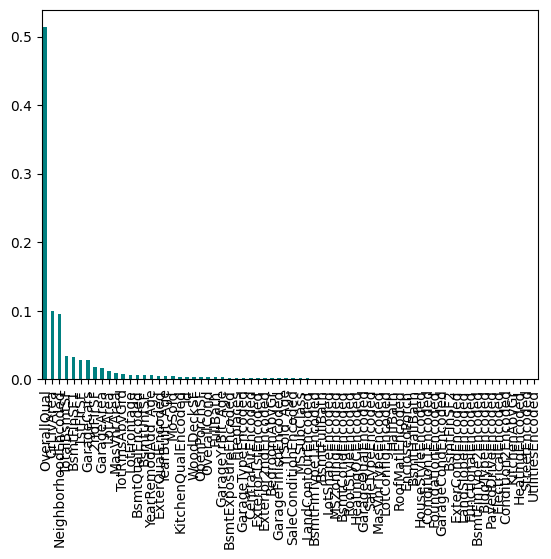

In [ ]:
feature_importance.plot(kind= 'bar', color = 'teal')

In [ ]:
final_feat = features[:15]+ ['SalePrice']

In [ ]:
f_imp2 = fn_RandomFReg(train_df.loc[:, final_feat], 'SalePrice', 500)

No. of features used :  15
Training Features Shape:  (1314, 15)
Training Labels Shape:  (1314,)
Testing Features Shape:  (146, 15)
Testing Labels Shape:  (146,)
R2 score(model) : 0.8804099581502046
R2 score(actual) :  0.8804099581502046
Mean absolute error :  17696.21065322896
Mean absolute percentage error :  0.09629718106459749
R2 score(actual) :  0.8804099581502046


<Axes: >

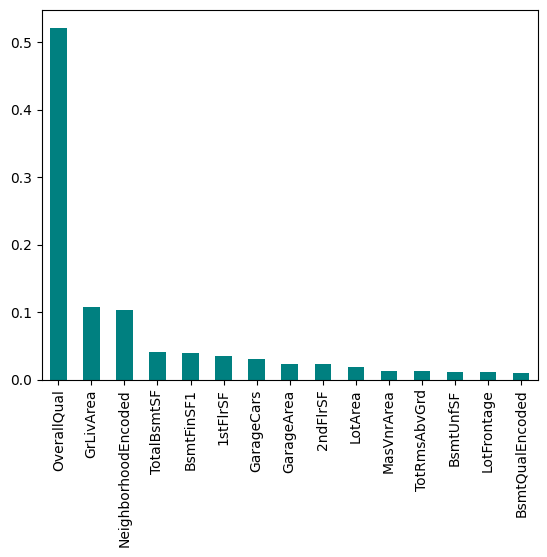

In [ ]:
feature_importance2 = pd.Series(f_imp2, train_df.loc[:, final_feat].drop(columns= ['SalePrice']).columns)
feature_importance2.sort_values(ascending=False, inplace=True)
features = list(feature_importance2.index)
feature_importance2.plot(kind= 'bar', color = 'teal')

# Parse Forest

In [ ]:
fn_RandomFReg(train_df.loc[:, final_feat], 'SalePrice', 10)

No. of features used :  15
Training Features Shape:  (1314, 15)
Training Labels Shape:  (1314,)
Testing Features Shape:  (146, 15)
Testing Labels Shape:  (146,)
R2 score(model) : 0.8889287001807422
R2 score(actual) :  0.8889287001807422
Mean absolute error :  18041.47283105023
Mean absolute percentage error :  0.10100968281394881
R2 score(actual) :  0.8889287001807422


[0.5147161534075908,
 0.1097760128376308,
 0.08588085215069477,
 0.050318381629253936,
 0.04154572256150647,
 0.03860475205024356,
 0.021858868409887912,
 0.025189638313676162,
 0.026194154902353516,
 0.021857801329084547,
 0.006754772436070698,
 0.015312788518342165,
 0.010714513944685011,
 0.0198835180661185,
 0.011392069442861173]

# Really dense Forest

In [ ]:
fn_RandomFReg(train_df.loc[:, final_feat], 'SalePrice', 2000)

No. of features used :  15
Training Features Shape:  (1314, 15)
Training Labels Shape:  (1314,)
Testing Features Shape:  (146, 15)
Testing Labels Shape:  (146,)
R2 score(model) : 0.8783283576373819
R2 score(actual) :  0.8783283576373819
Mean absolute error :  17749.88744827136
Mean absolute percentage error :  0.0964420393744842
R2 score(actual) :  0.8783283576373819


[0.5249219819339541,
 0.10991600075177775,
 0.10257550305057668,
 0.04035152767671121,
 0.03939634297669475,
 0.03435414989537162,
 0.028826301732900544,
 0.021177792551963302,
 0.022160757434389614,
 0.019644626240031354,
 0.012466534559939398,
 0.011990324922270534,
 0.011783970630999955,
 0.009304426963813148,
 0.01112975867860606]

No significant effect over increasing the n-estimators form 500 to 2000

I will try Linear Regression with only 15 features selected from Random forest. Let's see what happens

In [ ]:
final_feat + ['Id']

['OverallQual',
 'GrLivArea',
 'NeighborhoodEncoded',
 'TotalBsmtSF',
 'BsmtFinSF1',
 '1stFlrSF',
 'GarageCars',
 '2ndFlrSF',
 'GarageArea',
 'LotArea',
 'MasVnrArea',
 'TotRmsAbvGrd',
 'LotFrontage',
 'BsmtQualEncoded',
 'BsmtUnfSF',
 'SalePrice',
 'Id']

In [ ]:
fn_LinearReg(train_df.loc[:, ['Id']+final_feat], 'SalePrice')

No. of features used :  16
Training Features Shape:  (1314, 15)
Training Labels Shape:  (1314,)
Testing Features Shape:  (146, 15)
Testing Labels Shape:  (146,)
R2 score(model) : 0.7839834695700804
R2 score(actual) :  0.7839834695700804
Mean absolute error :  23990.870022519997
Mean absolute percentage error :  0.13314992145115823
R2 score(actual) :  0.7839834695700804


(0.7839834695700804, 0.13314992145115823)

A slight drop in accuracy

Let's do some Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4, 5, 6, 7, 8]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 3, 4],
 'min_samples_split': [2, 3, 4, 5, 6, 7, 8],
 'n_estimators': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000]}


In [ ]:
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                               n_iter = 100, cv = 3, verbose=2, random_state=42,
                               n_jobs = -1)
# Fit the random search model
X = train_df.loc[:, final_feat]
target = 'SalePrice'
Y = X[target]
scale = MinMaxScaler()
X_scaled = scale.fit_transform(X.drop(columns= [target]))
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.1, random_state=0)
print('Training Features Shape: ', X_train.shape)
print('Training Labels Shape: ', y_train.shape)
print('Testing Features Shape: ', X_test.shape)
print('Testing Labels Shape: ', y_test.shape)

rf_random.fit(X_train, y_train)

Training Features Shape:  (1314, 15)
Training Labels Shape:  (1314,)
Testing Features Shape:  (146, 15)
Testing Labels Shape:  (146,)
Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8],
                                        'n_estimators': [10, 120, 230, 340, 450,
                                                         560, 670, 780, 890,
                                                         1000]},
                   random_state=42, verbose=2)

In [ ]:
best_random = rf_random.best_estimator_

y_pred_best = best_random.predict(X_test)

In [ ]:
r2_score(y_test, y_pred_best)

0.8683418424143095

In [ ]:
mean_absolute_percentage_error(y_test, y_pred_best)

0.09589563132462228

So With Random Search of Hyperparameters We were actually abel to improve the accuracy to 90%

Lets perform Grid search to fine tune the hyperparameters found in Random Searhc

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
rf_random.best_params_

{'n_estimators': 450,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': False}

In [ ]:

# Create the parameter grid based on the results of random search
param_grid = {
    'bootstrap': [False, True],
    'max_depth': [45, 50, 55],
    'min_samples_leaf': [1],
    'min_samples_split': [4, 5, 6],
    'n_estimators': [450]
}
# Create a based model
rf_grid = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf_grid, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [False, True], 'max_depth': [45, 50, 55],
                         'min_samples_leaf': [1],
                         'min_samples_split': [4, 5, 6],
                         'n_estimators': [450]},
             verbose=2)

In [ ]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 45,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 450}

In [ ]:
best_grid = grid_search.best_estimator_

y_pred_grid_best = best_grid.predict(X_test)

In [ ]:
r2_score(y_test, y_pred_grid_best)

0.8721269034875299

In [ ]:
mean_absolute_percentage_error(y_test, y_pred_grid_best)

0.09568717103636563